# Adapt VQE for the hydrogen molecule



1. Setting up molecule...

---FERMIONIC HAMILTONIAN---
 Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.471896007281142 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.471896007281142 * ( +_3 -_3 )
+ 0.3378550774017582 * ( +_0 +_0 -_0 -_0 )
+ 0.3322908651276483 * ( +_0 +_1 -_1 -_0 )
+ 0.3378550774017582 * ( +_0 +_2 -_2 -_0 )
+ 0.3322908651276483 * ( +_0 +_3 -_3 -_0 )
+ 0.09046559989211571 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211571 * ( +_0 +_1 -_0 -_1 )
+ 0.09046559989211571 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211571 * ( +_0 +_3 -_2 -_1 )
+ 0.09046559989211571 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211571 * ( +_1 +_1 -_0 -_0 )
+ 0.09046559989211571 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211571 * ( +_1 +_3 -_2 -_0 )
+ 0.3322908651276483 * ( +_1 +_0 -_0 -_1 )
+ 0.3492868613660083 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276483 * ( +_1 +_2 -_2 -_1 )
+ 0.3492868613660083 * ( +_1 +_3 -_3 -_1 )
+ 0.3378550774017582 * ( +_2 +_0 -_0 -_2 )
+ 0.3322

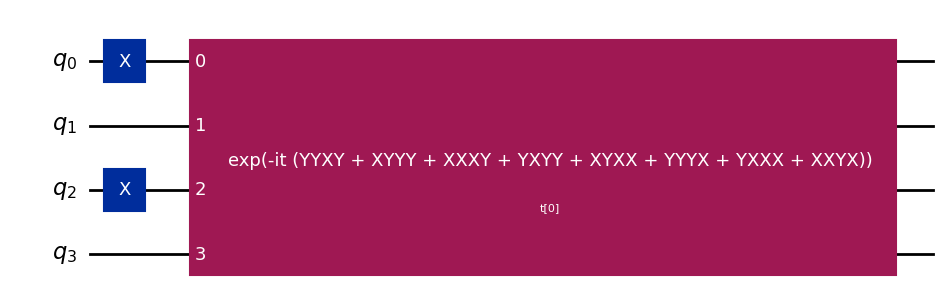

---FINAL CIRCUIT FORM (DECOMPOSED)---


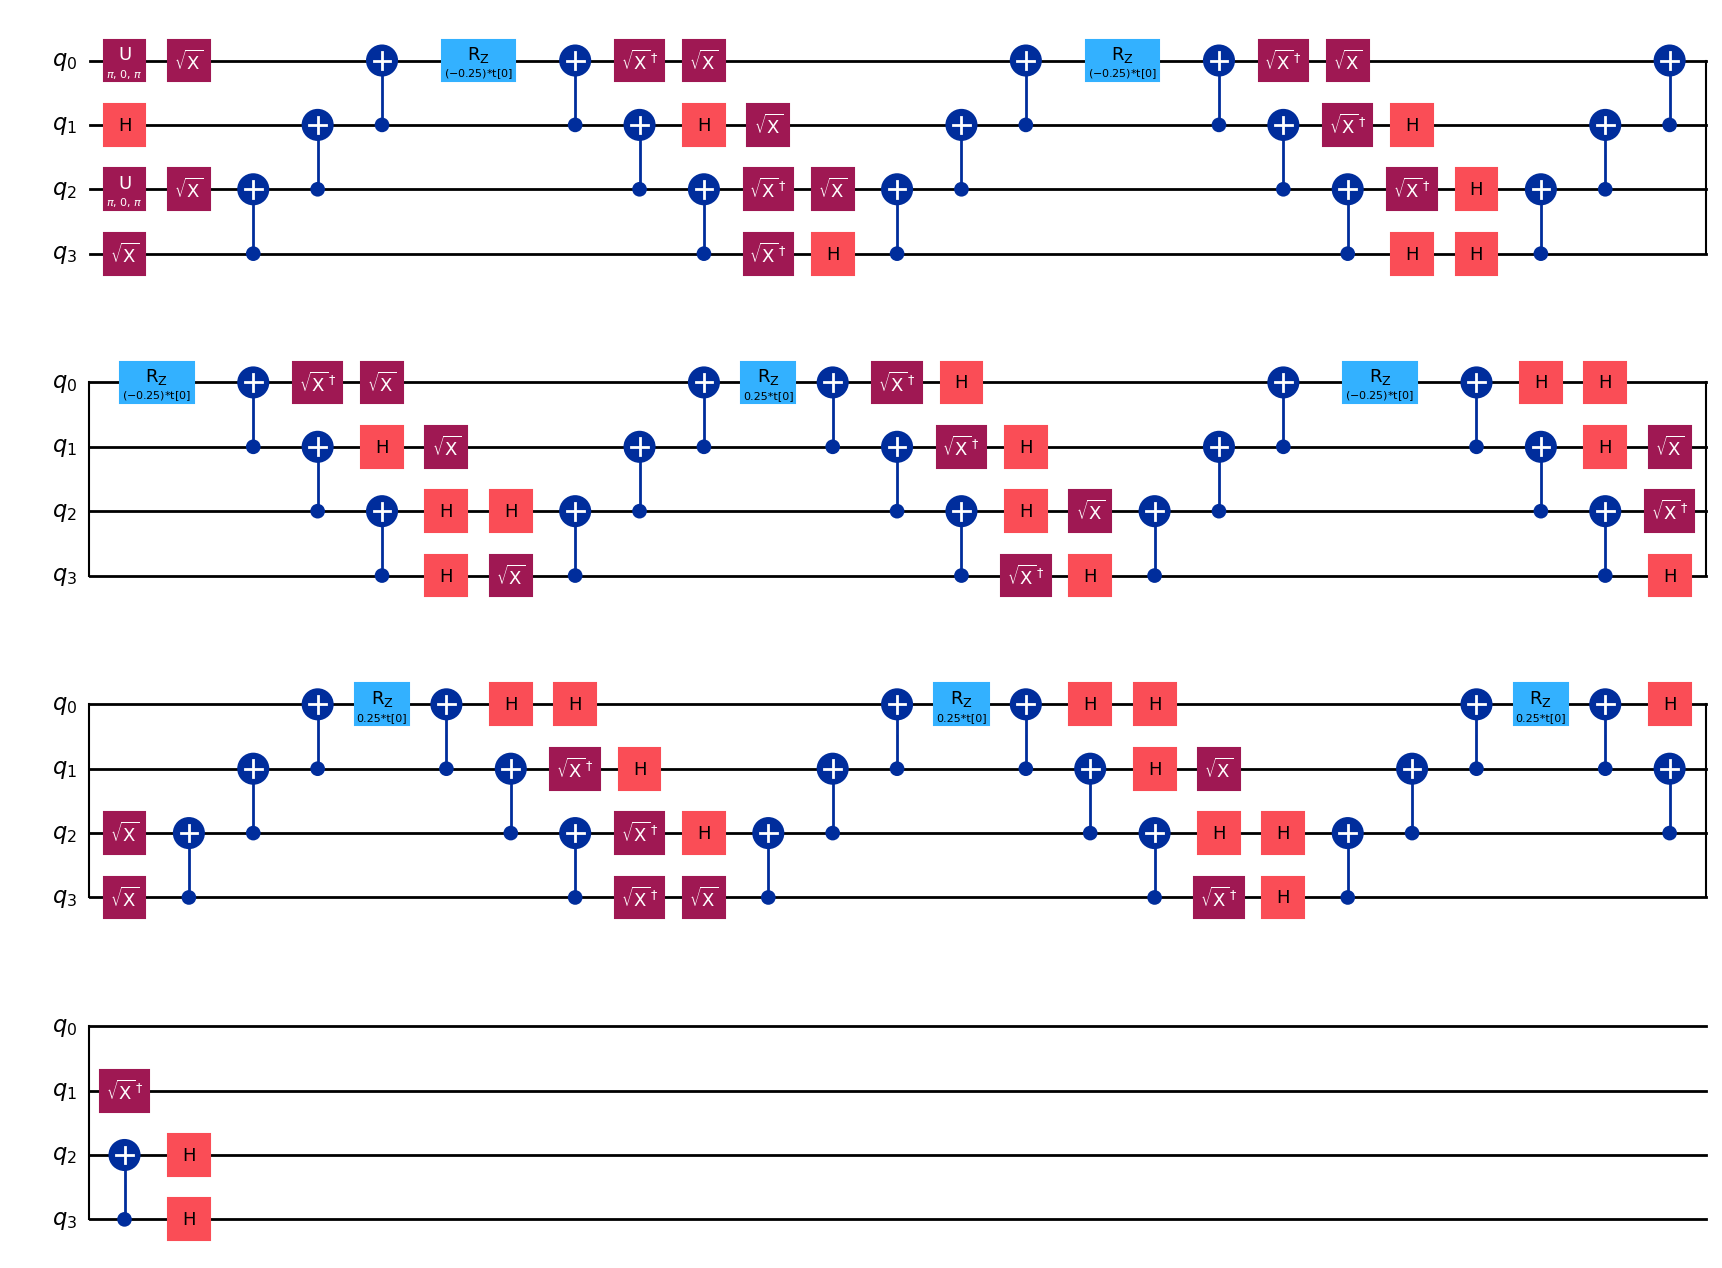

In [28]:
import numpy as np

# Qiskit imports
from qiskit_algorithms import VQE, AdaptVQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

import warnings

# Filter out SparseEfficiencyWarning
warnings.filterwarnings('ignore', category=RuntimeWarning) 
# Note: Scipy sparse warnings often manifest as RuntimeWarning or specific ImportWarning depending on version. 
# To target specifically SparseEfficiencyWarning without importing it from scipy:
warnings.filterwarnings('ignore', message='splu converted its input to CSC format')
warnings.filterwarnings('ignore', message='spsolve is more efficient when sparse b is in the CSC matrix format')




def run_adapt_vqe():
    # ------------------------------------------------------------------
    # Define the chemistry problem (H2 molecule)
    # ------------------------------------------------------------------
    print("1. Setting up molecule...\n")
    driver = PySCFDriver(atom="H 0.0 0.0 0.0; H 0.0 0.0 0.735", charge=0, spin=0)
    problem = driver.run()

    # Get the fermionic Hamiltonian
    hamiltonian = problem.hamiltonian.second_q_op()
    print('---FERMIONIC HAMILTONIAN---\n', hamiltonian)

    # Map the fermionic Hamiltonian to qubit Hamiltonian using Jordan-Wigner mapping
    mapper = JordanWignerMapper()
    qubit_op = mapper.map(hamiltonian)
    print('\n---QUBIT HAMILTONIAN---\n', qubit_op)
    
    # Get system info for the ansatz
    num_spatial_orbitals = problem.num_spatial_orbitals
    num_particles = problem.num_particles

    # ------------------------------------------------------------------
    # Define the ansatz and operator pool
    # ------------------------------------------------------------------
    # AdaptVQE requires an ansatz that is an 'EvolvedOperatorAnsatz'.
    # UCCSD is perfect for this as it contains the pool of excitations.
    print("\n2. Constructing operator pool via UCCSD...\n")
    
    initial_state = HartreeFock(
        num_spatial_orbitals,
        num_particles,
        mapper
    )

    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=initial_state
    )

    # 1. Access the list of operators (excitations)
    # The UCCSD ansatz automatically generates these based on the molecule
    full_pool = ansatz.operators

    print(f"---OPERATOR POOL GENERATED BY UCCSD---")
    print(f"Total operators in pool: {len(full_pool)}")

    # 2. Print the first few operators to inspect them
    # They are stored as Pauli/Fermionic op representations
    for i, op in enumerate(full_pool):
        print(f"  Operator {i}: {op}")


    # ------------------------------------------------------------------
    # Configure the base VQE solver
    # ------------------------------------------------------------------
    print("\n3. Configuring VQE...")
    
    # We use the standard StatevectorEstimator primitive
    estimator = Estimator()
    
    # Classical optimizer
    optimizer = SLSQP()

    # Create the VQE instance
    # Note: AdaptVQE will modify this ansatz, starting from 0 operators
    vqe = VQE(estimator, ansatz, optimizer)

    # ------------------------------------------------------------------
    # Configure and run AdaptVQE
    # ------------------------------------------------------------------
    print("4. Running AdaptVQE...")
    
    # AdaptVQE wrapper
    # gradient_threshold: Stops when gradient of all remaining operators is small
    adapt_vqe = AdaptVQE(vqe, gradient_threshold=1e-3)
    
    # Compute the result
    result = adapt_vqe.compute_minimum_eigenvalue(qubit_op)

    print("\n--- OPERATORS SELECTED FROM THE POOL ---")
    # 1. Access the final evolved ansatz from the solver
    # AdaptVQE updates this ansatz iteratively
    final_ansatz = vqe.ansatz 

    # 2. Extract the operators that were actually chosen
    # The ansatz is now an EvolvedOperatorAnsatz containing only the selected pool members
    selected_operators = final_ansatz.operators
    
    print(f"Number of operators selected: {len(selected_operators)}")
    print("\nSelected Operators (in order of addition):")
    
    # 3. Print them (and find their original index in the pool)
    for step, op in enumerate(selected_operators):
        try:
            original_idx = full_pool.index(op)
            idx_str = f"(Pool index: {original_idx})"
        except ValueError:
            idx_str = "(Index lookup failed)"
            
        print(f"  Step {step + 1}: {op} {idx_str}")

    # 4. View the convergence (eigenvalues)
    print("\n---ENERGY CONVERGENCE HISTORY---")
    print(result.eigenvalue_history)


    # ------------------------------------------------------------------
    # Output results
    # ------------------------------------------------------------------
    print("\n--- RESULTS ---")
    print(f"Converged energy: {result.eigenvalue.real:.5f} Ha")
    print(f"Number of iterations: {result.num_iterations}")
    print(f"Final circuit depth: {result.eigenvalue_history.__len__()}")
    print(f"Termination criterion: {result.termination_criterion}")
    
    # Optional: Compare with exact eigensolver if system is small
    from qiskit_algorithms import NumPyMinimumEigensolver
    exact_solver = NumPyMinimumEigensolver()
    exact_result = exact_solver.compute_minimum_eigenvalue(qubit_op)
    print(f"Exact energy:     {exact_result.eigenvalue.real:.5f} Ha")

    print(f"\n---FINAL CIRCUIT FORM (BEFORE DECOMPOSITION)---")
    display(ansatz.decompose(reps=1).draw('mpl'))
    print(f"---FINAL CIRCUIT FORM (DECOMPOSED)---")
    display(ansatz.decompose(reps=2).draw('mpl'))

if __name__ == "__main__":
    run_adapt_vqe()
    

In [19]:
%pip list | grep qiskit

qiskit                  2.2.3
qiskit-aer              0.17.2
qiskit-algorithms       0.4.0
qiskit-ibm-runtime      0.44.0
qiskit-nature           0.7.2
Note: you may need to restart the kernel to use updated packages.


<div style="background-color:#f0f0f0; padding:10px; border-radius:5px;">
This code is a part of Quantum AI Biomedical Research Lab project 
    
`Estimating molecular ground and excited state energies on quantum computers'
    
© Copyright Renata Wong, 2026.

This code is licensed under the CC BY-NC 4.0 License. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at https://creativecommons.org/licenses/by-nc/4.0/deed.en.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.
</div>

<div style="background-color:#f0f0f0; padding:10px; border-radius:5px;">
This work was supported by the National Science and Technology Council (Taiwan) grant No. NSTC 114-2112-M-182-002-MY3 and Chang Gung Memorial Hospital grant No. BMRPL94.

This work comes with an accompanying paper titled 'Quantum circuit compilation for fermionic excitations using the Jordan-Wigner mapping'.
</div>